This time, while scrolling through the competition forum I ran into an interesting technique - Recursive Feature Elimination!
So in this approach we try to implement RFE to our logistic regression model, and see how well it performs

In [7]:
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import numpy as np
from boruta import BorutaPy
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler,MinMaxScaler, RobustScaler
from sklearn.feature_selection import SelectFromModel
from sklearn import model_selection
from sklearn.metrics import accuracy_score, roc_auc_score
from eli5.sklearn import PermutationImportance
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import featuretools as ft
import json
import ast
import time
from sklearn import linear_model
import eli5
import gc
gc.enable()
gc.collect()

14

In [4]:
train_df = pd.read_csv("/Users/JoonH/dont-overfit-ii/train.csv")
test_df = pd.read_csv("/Users/JoonH/dont-overfit-ii/test.csv")

In [51]:
x_train = train_df.drop(['target','id'],axis=1)
y_train = train_df['target']
x_test = test_df.drop(['id'],axis=1)

n_fold = 20
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

In [ ]:
# Adding noise to prevent overfitting
noise_std = 0.01
x_train += np.random.normal(0, noise_std, x_train.shape)

In [52]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [54]:
def train_model(X, X_test, y, params, folds=folds, model_type='lgb', plot_feature_importance=False, averaging='usual', model=None):
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        # print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'lgb':
            train_data = lgb.Dataset(X_train, label=y_train)
            valid_data = lgb.Dataset(X_valid, label=y_valid)
            
            model = lgb.train(params,
                    train_data,
                    num_boost_round=2000,
                    valid_sets = [train_data, valid_data],
                    verbose_eval=500,
                    early_stopping_rounds = 200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X_tr.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X_tr.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X_tr.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X_tr.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=20000,  eval_metric='AUC', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
            
            
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            # print(f'Fold {fold_n}. AUC: {score:.4f}.')
            # print('')
            
            y_pred = model.predict_proba(X_test)[:, 1]
            
            
        if model_type == 'glm':
            model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
            model_results = model.fit()
            model_results.predict(X_test)
            y_pred_valid = model_results.predict(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            
            y_pred = model_results.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(roc_auc_score(y_valid, y_pred_valid))

        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values  
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction, scores
    
    else:
        return oof, prediction, scores

In [55]:
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
oof_lr, prediction_lr, _ = train_model(x_train, x_test, y_train, params=None, model_type='sklearn', model=model)

CV mean score: 0.7144, std: 0.1206.


In [56]:
from sklearn.feature_selection import RFECV
selector = RFECV(model,1,20, cv=StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42),scoring='roc_auc') 
selector = selector.fit(x_train,y_train)

Optimal number of features : 26


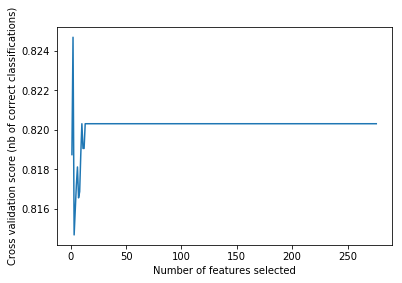

In [57]:
print("Optimal number of features : %d" % selector.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()

In [58]:
predictions = selector.predict_proba(x_test)
results = predictions[:,1]
predictions = pd.DataFrame(results, columns = ['target'])
ids = test_df['id']
predictions = pd.concat([ids, predictions], axis = 1, sort=False)
predictions.to_csv('dont_overfit_2_approach3_RFECV.csv',index = False)

In [41]:
selector.score(x_train,y_train)

0.856

This gives us a LB score of 0.849

# sum bootstrapping

As a followup, since this has our highest score let's try bootstrapping a bit of our prediction to generalize

In [238]:
#test_df.reset_index(drop=True, inplace=True)
#predictions.reset_index(drop=True, inplace=True)

In [379]:
bootstrap = pd.concat([predictions,test_df],axis=1)
bootstrap.head()

,id,target,id,0,1,2,3,4,5,6,...,290,291,292,293,294,295,296,297,298,299
0,250,0.693150,250,0.500,-1.033,-1.595,0.309,-0.714,0.502,0.535,...,-0.088,-2.628,-0.845,2.078,-0.277,2.132,0.609,-0.104,0.312,0.979
1,251,0.462844,251,0.776,0.914,-0.494,1.347,-0.867,0.480,0.578,...,-0.683,-0.066,0.025,0.606,-0.353,-1.133,-3.138,0.281,-0.625,-0.761
2,252,0.535151,252,1.750,0.509,-0.057,0.835,-0.476,1.428,-0.701,...,-0.094,0.351,-0.607,-0.737,-0.031,0.701,0.976,0.135,-1.327,2.463
3,253,0.778796,253,-0.556,-1.855,-0.682,0.578,1.592,0.512,-1.419,...,-0.336,-0.787,0.255,-0.031,-0.836,0.916,2.411,1.053,-1.601,-1.529
4,254,0.438243,254,0.754,-0.245,1.173,-1.623,0.009,0.370,0.781,...,2.184,-1.090,0.216,1.186,-0.143,0.322,-0.068,-0.156,-1.153,0.825


In [360]:
import math
def normal_round(n):
    if n - math.floor(n) < 0.5:
        return math.floor(n)
    return math.ceil(n)

In [380]:
bootstrap['target'] = [normal_round(x) for x in bootstrap['target']]
bootstrap.head()

,id,target,id,0,1,2,3,4,5,6,...,290,291,292,293,294,295,296,297,298,299
0,250,1,250,0.500,-1.033,-1.595,0.309,-0.714,0.502,0.535,...,-0.088,-2.628,-0.845,2.078,-0.277,2.132,0.609,-0.104,0.312,0.979
1,251,0,251,0.776,0.914,-0.494,1.347,-0.867,0.480,0.578,...,-0.683,-0.066,0.025,0.606,-0.353,-1.133,-3.138,0.281,-0.625,-0.761
2,252,1,252,1.750,0.509,-0.057,0.835,-0.476,1.428,-0.701,...,-0.094,0.351,-0.607,-0.737,-0.031,0.701,0.976,0.135,-1.327,2.463
3,253,1,253,-0.556,-1.855,-0.682,0.578,1.592,0.512,-1.419,...,-0.336,-0.787,0.255,-0.031,-0.836,0.916,2.411,1.053,-1.601,-1.529
4,254,0,254,0.754,-0.245,1.173,-1.623,0.009,0.370,0.781,...,2.184,-1.090,0.216,1.186,-0.143,0.322,-0.068,-0.156,-1.153,0.825


In [381]:
bootstrap = bootstrap.drop(['id'],axis=1)
bootstrap = bootstrap[0:100:10]
bootstrap.head()

,target,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,1,0.500,-1.033,-1.595,0.309,-0.714,0.502,0.535,-0.129,-0.687,...,-0.088,-2.628,-0.845,2.078,-0.277,2.132,0.609,-0.104,0.312,0.979
10,1,1.208,-2.625,-0.417,1.182,0.151,-0.457,-0.080,1.658,-1.032,...,0.541,-1.735,-1.349,-1.128,1.001,0.338,0.531,0.771,0.977,-0.822
20,0,0.155,0.549,-0.368,-0.545,0.898,0.255,0.871,0.232,-0.437,...,0.620,0.009,-2.061,0.531,-0.642,-0.671,0.737,-0.036,0.596,0.422
30,0,-0.973,-0.306,0.412,0.540,-0.862,0.714,1.272,-1.209,0.797,...,-0.190,0.433,-1.085,-1.455,0.286,-0.793,0.353,1.239,0.887,-0.750
40,0,-0.489,1.216,-1.062,-1.382,-1.120,-1.043,-2.030,1.948,0.539,...,0.729,1.250,1.295,0.979,-0.897,0.344,0.523,1.275,1.191,0.019


In [382]:
train_df.head()

,id,target,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,0,1.0,-0.098,2.165,0.681,-0.614,1.309,-0.455,-0.236,0.276,...,0.867,1.347,0.504,-0.649,0.672,-2.097,1.051,-0.414,1.038,-1.065
1,1,0.0,1.081,-0.973,-0.383,0.326,-0.428,0.317,1.172,0.352,...,-0.165,-1.695,-1.257,1.359,-0.808,-1.624,-0.458,-1.099,-0.936,0.973
2,2,1.0,-0.523,-0.089,-0.348,0.148,-0.022,0.404,-0.023,-0.172,...,0.013,0.263,-1.222,0.726,1.444,-1.165,-1.544,0.004,0.800,-1.211
3,3,1.0,0.067,-0.021,0.392,-1.637,-0.446,-0.725,-1.035,0.834,...,-0.404,0.640,-0.595,-0.966,0.900,0.467,-0.562,-0.254,-0.533,0.238
4,4,1.0,2.347,-0.831,0.511,-0.021,1.225,1.594,0.585,1.509,...,0.898,0.134,2.415,-0.996,-1.006,1.378,1.246,1.478,0.428,0.253


In [383]:
comb_df = pd.concat([bootstrap,train_df.drop(['id'],axis=1)],axis=0)
comb_df.head()

,target,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,1.0,0.500,-1.033,-1.595,0.309,-0.714,0.502,0.535,-0.129,-0.687,...,-0.088,-2.628,-0.845,2.078,-0.277,2.132,0.609,-0.104,0.312,0.979
10,1.0,1.208,-2.625,-0.417,1.182,0.151,-0.457,-0.080,1.658,-1.032,...,0.541,-1.735,-1.349,-1.128,1.001,0.338,0.531,0.771,0.977,-0.822
20,0.0,0.155,0.549,-0.368,-0.545,0.898,0.255,0.871,0.232,-0.437,...,0.620,0.009,-2.061,0.531,-0.642,-0.671,0.737,-0.036,0.596,0.422
30,0.0,-0.973,-0.306,0.412,0.540,-0.862,0.714,1.272,-1.209,0.797,...,-0.190,0.433,-1.085,-1.455,0.286,-0.793,0.353,1.239,0.887,-0.750
40,0.0,-0.489,1.216,-1.062,-1.382,-1.120,-1.043,-2.030,1.948,0.539,...,0.729,1.250,1.295,0.979,-0.897,0.344,0.523,1.275,1.191,0.019


In [368]:
comb_df.isnull().sum().sum()

0

In [384]:
x_train = comb_df.drop(['target'],axis=1)
y_train = comb_df['target'].astype('float64')
x_test = test_df.drop(['id'],axis=1)

n_fold = 20
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
scaler = StandardScaler()
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [332]:
np.any(np.isnan(x_train))

False

In [370]:
np.where(comb_df.values >= np.finfo(np.float64).max)

(array([], dtype=int64), array([], dtype=int64))

In [385]:
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
oof_lr, prediction_lr, _ = train_model(x_train, x_test, y_train, params=None, model_type='sklearn', model=model)

CV mean score: 0.7125, std: 0.0721.


In [386]:
from sklearn.feature_selection import RFECV
selector = RFECV(model,1,25, cv=StratifiedKFold(n_splits=20, shuffle=True, random_state=42),scoring='roc_auc') 
selector = selector.fit(x_train,y_train)

Optimal number of features : 34


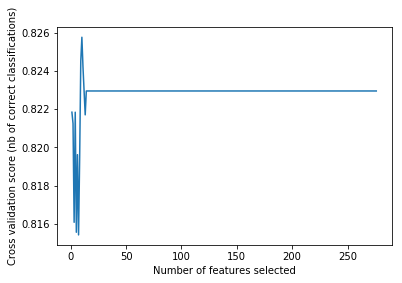

In [387]:
print("Optimal number of features : %d" % selector.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()

In [388]:
predictions2 = selector.predict_proba(x_test)
results = predictions2[:,1]
predictions2 = pd.DataFrame(results, columns = ['target'])
ids = test_df['id']
predictions2 = pd.concat([ids, predictions2], axis = 1, sort=False)
predictions2.to_csv('dont_overfit_2_approach3_RFECV+bootstrap.csv',index = False)

In [377]:
predictions2.head()

,id,target
0,250,0.728204
1,251,0.397405
2,252,0.513635
3,253,0.809781
4,254,0.269461


This doesn't particularly help us as we get a LB score of 0.845, hmm.. seems like the model is overfitting further by introducing samples that it labelled on its own.